In [1]:
%matplotlib inline
import dataset
import numpy as np
import matplotlib.pyplot as plt

db = dataset.connect('sqlite:///dds_params.db')
q = "SELECT * from chirp_rates ORDER BY chirp" ##WHERE chirp > 22.9 AND chirp < 23.1 
rows = db.query(q)
chirps_d = {r['chirp']: r for r in rows}
chirps = np.unique(np.array(list(chirps_d.keys())))
# print(list(chirps_d.keys()))
# print(chirps)

In [2]:
def fil(chirp_start, end_chirp, dc, tolerance):
    return end_chirp >= (chirp_start + dc - tolerance) and end_chirp <= (chirp_start + dc + tolerance)

def get_fringe_points(start_alpha, end_alpha, num_points, dc = 0, tolerance = 0, plot=False):
    all_sets = []
    all_errors = []
    
    if dc == 0:
        dc = (end_alpha - start_alpha) / num_points
    if tolerance == 0:
        tolerance = dc/5
#     print(dc)
    for i in range(len(chirps)):
        c = chirps[i]
        if c < start_alpha or c > end_alpha:
            continue
        points = 1
        pset = []
        errors = 0
        pset.append(c)
        while points < num_points:
            j = i
            matches = dict()
            curr_chirp = pset[-1]
            while len(matches) == 0 and j < len(chirps) and chirps[j] < curr_chirp + dc + tolerance:
                if fil(curr_chirp, chirps[j], dc, tolerance):
                    matches[chirps[j]] = np.abs(curr_chirp + dc - chirps[j])
                    break
                j +=1
            if len(matches) == 0:
                break
            else:
                points+=1
                pset.append(min(matches, key=lambda x: matches[x]))
                errors += matches[min(matches, key=lambda x: matches[x])]


        if points == num_points:
            all_sets.append(pset)
            all_errors.append(errors)
            break

    if len(all_sets) == 0:
        return None
    
    all_sets = sorted(all_sets, key=lambda x: all_errors[all_sets.index(x)])
    best_set = all_sets[0]
    if plot:
        print(best_set)
        x = range(len(best_set))
        plt.scatter(x, best_set)
        plt.ylim(best_set[0], best_set[-1])
        plt.show()
    return best_set

In [3]:
c = 299792458
k1_f = 351.720961e12 - 160e6
k2_f = 9.19263177e9 + 351.720961e12 - 160e6
k1_lambda = c / k1_f
k2_lambda = c / k2_f
k1 = 2 * np.pi / k1_lambda
k2 = 2 * np.pi / k2_lambda
keff = k1 + k2

g = 9.799e-6

def experiment_model(alpha, T):
    return 0.5 + 0.5*np.cos( (-2*np.pi*alpha + keff*g)*T*T)


# print( (np.pi/2 + keff*g)/(2*np.pi)*1e-6)

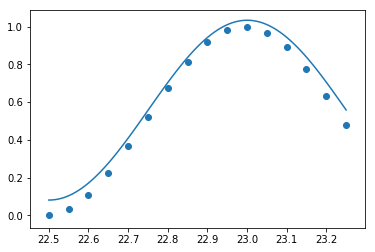

1.0
22.500505225183915
0.25


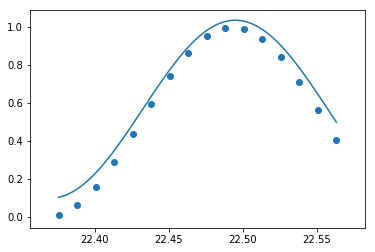

2.0
22.375517110015284
0.1111111111111111


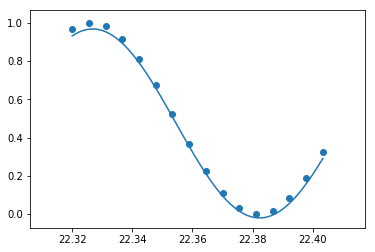

3.0
22.382333209085647
0.0625


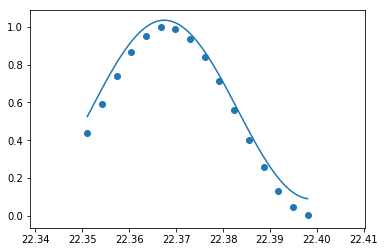

4.0
22.39803143538821
0.04


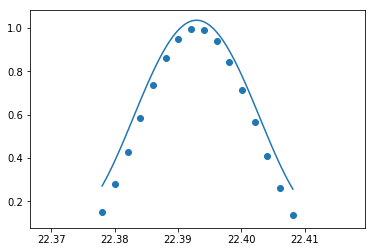

5.0
22.40813475935542
0.027777777777777776


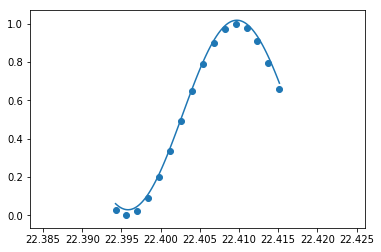

6.0
22.39583994872143
0.02040816326530612


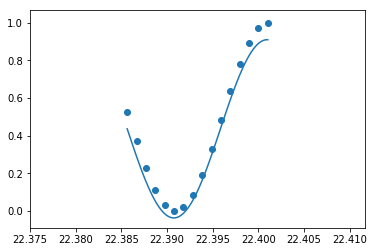

7.0
22.39074530945503
0.015625


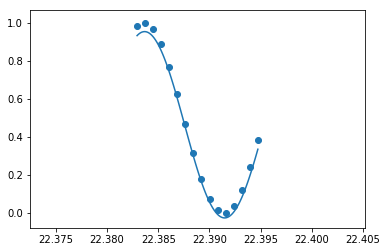

8.0
22.391481031786387
0.012345679012345678


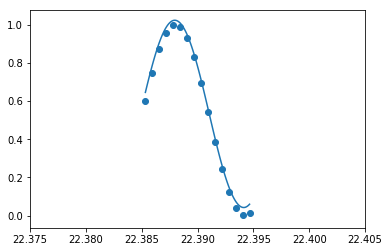

9.0
22.394126479911733
0.01


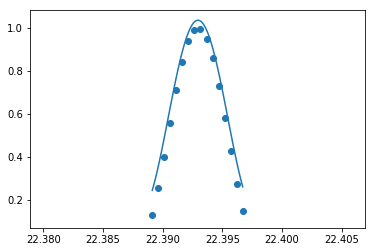

10.0
22.3891276771289
0.008264462809917356


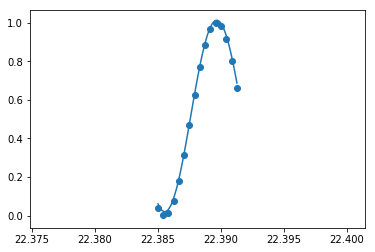

11.0
22.3855387916704
0.006944444444444444


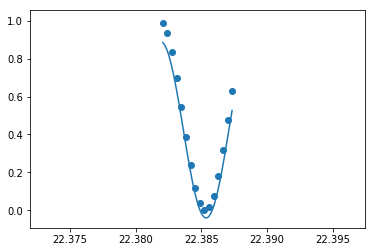

12.0
22.3853658154777
0.005917159763313609


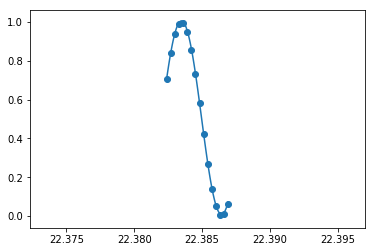

13.0
22.38643830752633
0.00510204081632653


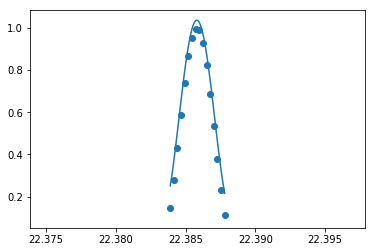

14.0
22.387804889522453
0.0044444444444444444


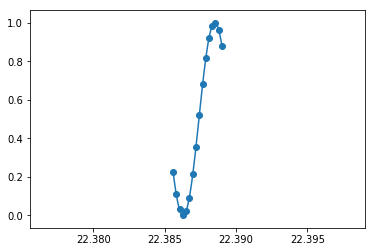

15.0
22.386287798244712
0.00390625


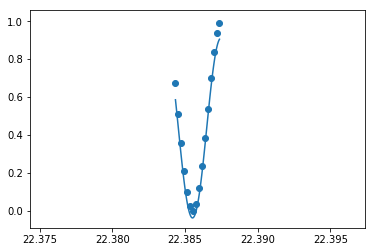

16.0
22.38551319625949
0.0034602076124567475


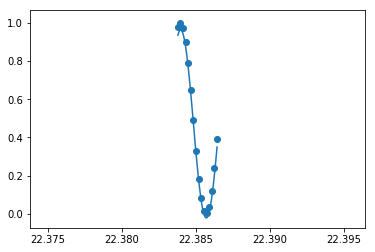

17.0
22.38570315347412
0.0030864197530864196


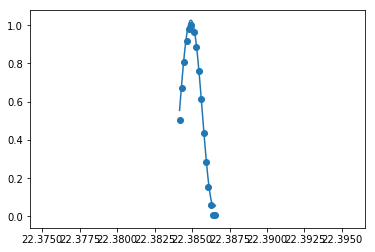

18.0
22.38645879194155
0.002770083102493075


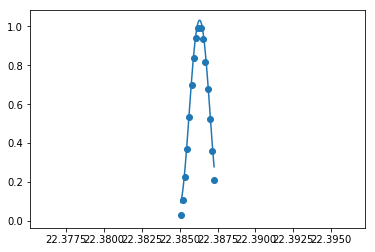

19.0
22.385074997354927
0.0025


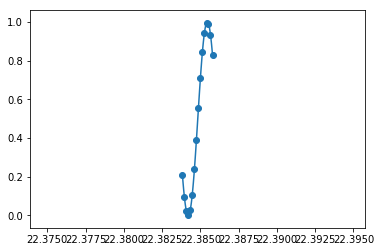

20.0
22.38420446520537
0.0022675736961451248


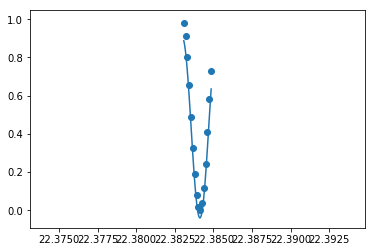

21.0
22.384121182657815
0.002066115702479339


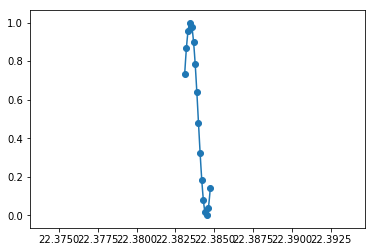

22.0
22.384483259040408
0.001890359168241966


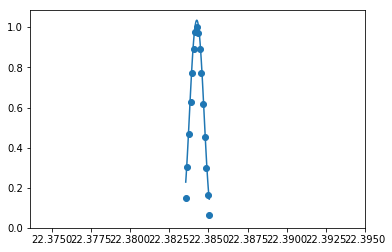

23.0
22.385049160948952
0.001736111111111111


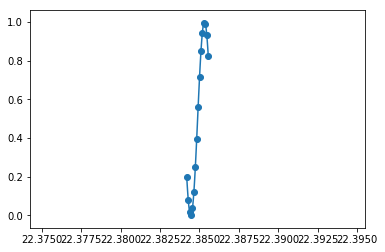

24.0
22.384447565324287
0.0016


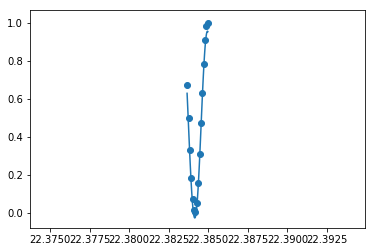

25.0
22.3841506714938
0.0014792899408284023


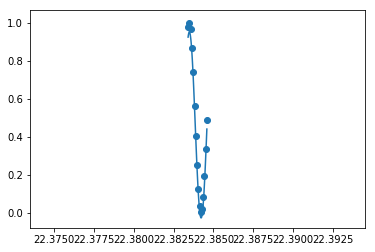

26.0
22.384232178602808
0.0013717421124828531


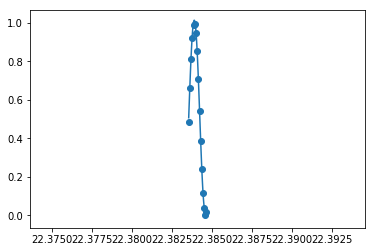

27.0
22.384584159390872
0.0012755102040816326


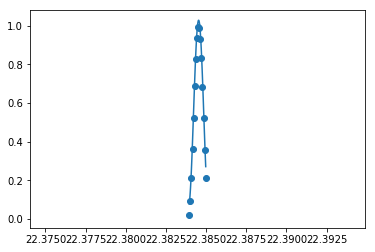

28.0
22.3839542173743
0.0011890606420927466


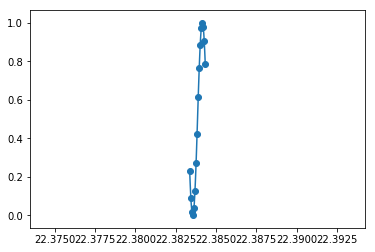

29.0
22.383560887777783
0.0011111111111111111


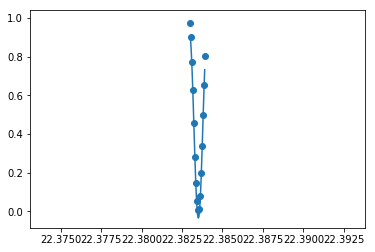

30.0
22.38351189345441
0.001040582726326743


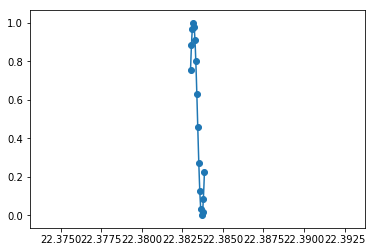

31.0
22.383693297042075
0.0009765625


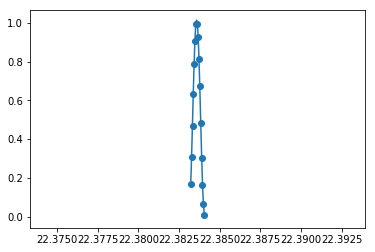

32.0
22.3840396751574
0.0009182736455463728


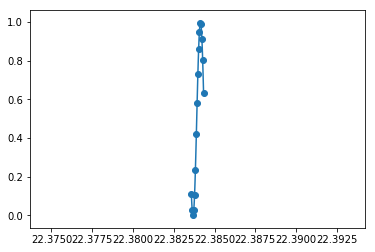

33.0
22.383679904466565
0.0008650519031141869


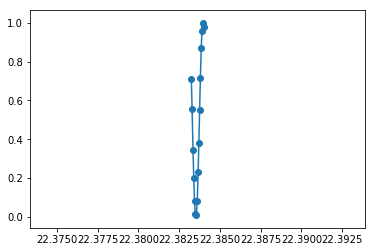

34.0
22.38352546994022
0.0008163265306122449


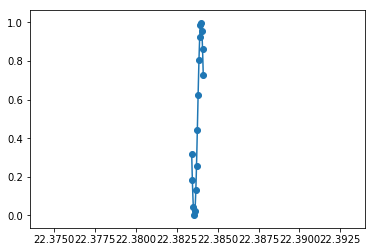

35.0
22.383566615078614
0.0007716049382716049


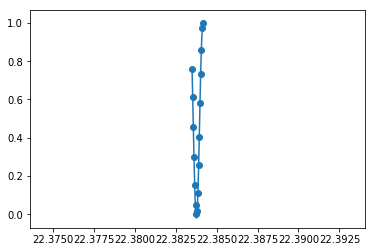

36.0
22.38377182079369
0.0007304601899196494


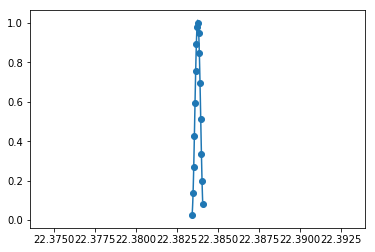

37.0
22.383422437955346
0.0006925207756232687


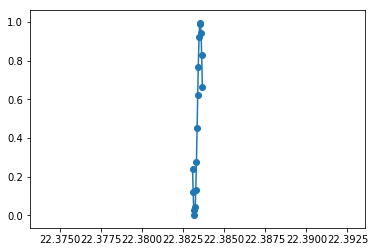

38.0
22.38318977775705
0.0006574621959237344


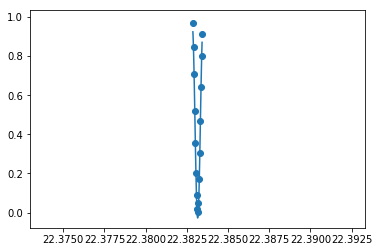

39.0
22.383158307134774
0.000625


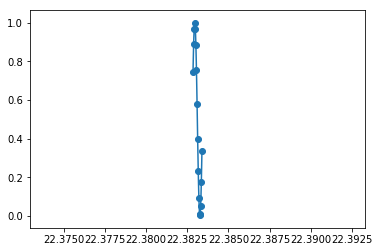

40.0
22.383266999030326
0.000594883997620464


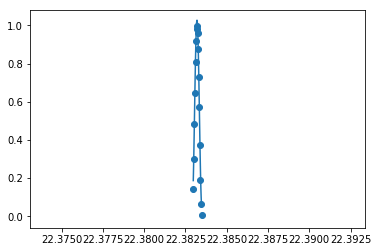

41.0
22.383481775361748
0.0005668934240362812


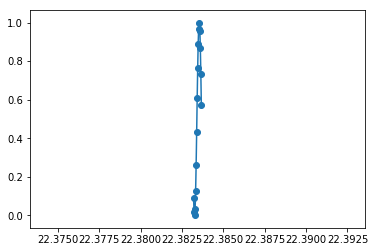

42.0
22.38326055365
0.0005408328826392645


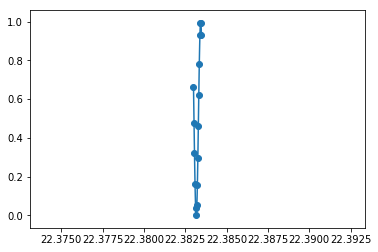

43.0
22.383165540047507
0.0005165289256198347


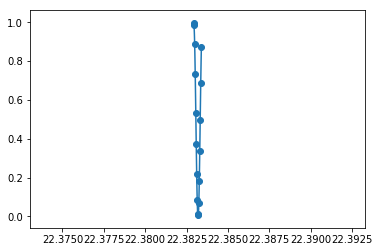

44.0
22.383192041869986
0.0004938271604938272


TypeError: 'NoneType' object is not iterable

In [4]:
from scipy.optimize import curve_fit, minimize_scalar

w_tolerance = 0.0001
bg_tolerance = 0.05
amp_tolerance = 0.25

chirpPeriod = lambda T: 1 / T**2

def fitExpData(chirps, pd, T):
    nominal_w = 2 * np.pi * T**2
    nominal_contrast = max(pd) - min(pd)
    nominal_background = np.average(pd)    
    
    def fitFunc(x, w, x0, b, c):
        return c/2*np.cos(w*(x - x0)) + b

    fitBounds = ([(1 - w_tolerance)*nominal_w, 0, (1 - bg_tolerance)*nominal_background, (1 - amp_tolerance)*nominal_contrast],
                 [(1 + w_tolerance)*nominal_w, 2*np.pi,(1 + bg_tolerance)*nominal_background, (1 + amp_tolerance)*nominal_contrast])
    fitParams, _ = curve_fit(fitFunc, chirps, pd, bounds=fitBounds, maxfev=2**64)
    return lambda x: fitFunc(x, *fitParams), fitParams[1]
    
T = 1.0
cp = chirpPeriod(T)
curr_chirps = get_fringe_points(23 - cp/2, 23 + cp/2, 16)
while T < 50:
    curr_pd = experiment(curr_chirps, T)
    plt.scatter(curr_chirps, curr_pd)
    fit, alpha = fitExpData(curr_chirps, curr_pd, T)
    x_fit = np.linspace(min(curr_chirps), max(curr_chirps), 100)
    y_fit = fit(x_fit)
    plt.plot(x_fit, y_fit)
    plt.show()
    alpha = minimize_scalar(fit, bounds=(min(curr_chirps), max(curr_chirps)), method='Bounded',
                            options={'xatol':1e-10, 'maxiter':2**64}).x
    print(T)
    print(alpha)
    T += 1.0
    cp = chirpPeriod(T)
    print(cp)
    min_alpha = alpha - cp/2
    max_alpha = alpha + cp/2
#     prev_chirps = curr_chirps
    curr_chirps = get_fringe_points(min_alpha, max_alpha, 16)
    
#     if curr_chirps == None:
#         curr_chirps = prev_chirps

In [ ]:
def get_dds_params(row, raman_detuning_khz, prefix, index, ref_clk = 10e6):
    chirp = row['chirp']
    if raman_detuning_khz < 0:
        chirp = -1 * chirp
    clock_transition = 12631770
    free_fall_time_s = .280
    mw_ramp_time_s = 0.010
    chirp_start_hz = raman_detuning_khz * 1000 + clock_transition
    chirp_stop_hz = chirp_start_hz + free_fall_time_s * 1000 * chirp * 1000
    sys_clk = row['mult'] * ref_clk
    sync_clk = sys_clk / 4
    mw_t_bits = row['t_bits']
    num_mw_steps = mw_ramp_time_s / ( mw_t_bits * 1/sync_clk)
    mw_delta_hz = np.abs(chirp_start_hz - clock_transition)/num_mw_steps
    freq_res = sys_clk /(2**32)
    clock_transition_word = int(clock_transition / freq_res)
    chirp_start_word = int(chirp_start_hz / freq_res)
    chirp_stop_word = int(chirp_stop_hz / freq_res)
    mw_delta_word = int(mw_delta_hz / freq_res)
    assert(mw_delta_word != 0)
    return """
constexpr DDSConfig::params_t %s_params_%d = {
    .mult = %d,
    .clk_transition_hex = 0x%x, //%.2f
    .chirp_start_hex = 0x%x, //%.2f
    .chirp_stop_hex = 0x%x, //%.2f
    .mw_time_hex = 0x%x,
    .mw_freq_hex = 0x%x, //%.2f
    .chirp_time_hex = 0x%x,
    .chirp_freq_hex = 0x%x, //%.2f
    .actual_chirp = %f,
    .detuning = %.2f
};
""" % (prefix, index,
       row['mult'],
       clock_transition_word, clock_transition_word*freq_res,
       chirp_start_word, chirp_start_word*freq_res,
       chirp_stop_word,chirp_stop_word*freq_res,
       mw_t_bits,
       mw_delta_word, mw_delta_word*freq_res,
       row['t_bits'],
       row['f_bits'],row['f_bits']*freq_res,
       chirp,
       raman_detuning_khz)


In [ ]:
chirp_list = get_fringe_points(22.992, 22.994, 20, 0.00001, 0.000005)

def make_fringe_params(chirp_list, detuning):
    for i, c in enumerate(chirp_list):
        row = chirps_d[c]
        chirp = row['chirp']
        print(get_dds_params(row, detuning, 'inter', i))
        
        
    declare = "constexpr size_t NUM_POINTS_INTER = %d; constexpr DDSConfig::params_t fringes[NUM_POINTS_INTER] = { " % (len(chirp_list))
    for j in range(len(chirp_list)):
        declare += "%s_params_%d, " % ('inter', j)
    declare += "};"
    print(declare)

make_fringe_params(chirp_list, -510)

In [ ]:
def make_spectroscopy_params(detuning_start, detuning_stop, step, nominal_chirp):
    query= """SELECT DISTINCT chirp, mult, t_bits, f_bits
               FROM chirp_rates
               WHERE chirp > %f AND chirp < %f AND mult = 20
               ORDER BY chirp""" % (nominal_chirp - 0.001, nominal_chirp + 0.001)
    row =  db.query(query).next()
    i = 0
    declare = ""
    for raman_detuning_khz in np.arange(detuning_start, detuning_stop + step, step):
        declare += get_dds_params(row, raman_detuning_khz,'spec', i)
        i += 1
    declare += "constexpr size_t NUM_POINTS_SPEC = %d; constexpr DDSConfig::params_t specs[NUM_POINTS_SPEC] = { " % (i)
    for j in range(i):
        declare += "%s_params_%d, " % ('spec', j)
    declare += "};"
    print(declare)
    
make_spectroscopy_params(-20, -3000, -20, 22.91)